# **Árvore de Regressão e Random Forest**

* Parte 1: Entendimento e divisão do dataset
* Parte 2: Aplicação do algoritmo DecisionTreeRegressor
* Parte 3: Avaliação de desempenho
* Parte 4: Aplicação do algoritmo RandomForest
* Parte 5: Avaliação de desempenho

In [4]:
#Bibliotecas necessárias, modelos e métricas do scikit-learn e outros
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer,Normalizer

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,\
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold, cross_val_predict, StratifiedKFold
from scipy.stats import uniform, randint

#Bibliotecas/funções matheus
from envcity_plot_lib import *

from alphasense_b_sensors.alphasense_sensors import *

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# <font color=white>**Parte 1**: Entendimento e divisão do dataset

Definição das variáveis
- so2 IAG
- so2_1 estação
- so2_2 estação
- so2_3 estação
- so2_4 estação
- so2_we (working electord)
- so2_ae (auxiliary electrodo)
- best_so

In [31]:
#Leitura da base de dados da estação grafana com os dados de CO
df_bestCO = pd.read_csv('best-co.csv')
df_ae = pd.read_csv("co_ae.csv")
df_we = pd.read_csv("co_we.csv")

#Conversão do timestamp em milissegundos para datetime
df_bestCO['time'] = pd.to_datetime(df_bestCO['time'], unit='ms')

#padronizando time nas tabelas
df_bestCO['time'] = pd.to_datetime(df_bestCO['time'], unit='ms').dt.round('1s')
df_ae['time'] = pd.to_datetime(df_ae['time']).dt.round('1s')
df_we['time'] = pd.to_datetime(df_we['time']).dt.round('1s')

#Limpeza das colunas de AE e WE (remover " ppb" e converter para float)
df_ae['CO_AE'] = df_ae['CO_AE'].str.replace(' ppb', '', regex=False).astype(float)
df_we['CO_WE'] = df_we['CO_WE'].str.replace(' ppb', '', regex=False).astype(float)

#Mesclagem com base na coluna 'time'
df = df_bestCO.merge(df_ae, on='time', how='inner') \
              .merge(df_we, on='time', how='inner')


#df_co.head()
df.dropna()
df

#ALPHASENSE. Designing a potentiostatic circuit. 2022. Disponível em: <https://www.alphasense.com/wp-content/uploads/2022/10/AAN\_105-03\_App-Note\_V0.pdf>.Citado na página 23

,time,CO,CO_AE,CO_WE
0,2025-02-22 15:18:16,815.469921,0.562,0.501
1,2025-02-22 15:19:29,815.479525,0.560,0.500
2,2025-02-22 15:20:42,815.589499,0.544,0.512
3,2025-02-22 15:26:19,815.503305,0.555,0.500
4,2025-02-22 15:29:38,815.488494,0.558,0.499
...,...,...,...,...
82714,2025-06-16 19:43:31,1829.584450,0.546,0.538
82715,2025-06-16 19:43:31,1829.584450,0.546,0.538
82716,2025-06-16 19:43:31,1829.584450,0.546,0.538
82717,2025-06-16 19:43:31,1829.584450,0.546,0.538


In [32]:
#Leitura da base de dados da estação IAG de São Paulo
#print(aqm.shape)
#print(aqm.describe())
aqm = pd.read_csv('envcity_aqm_df.csv')
aqm.head()

,time,e1_anem,e1_anem_volt,e1_co,e1_co_2,e1_co_3,e1_co_4,e1_co_ae,e1_co_we,e1_location,...,iag_pm25,iag_pmcoarse,iag_pressure,iag_rainfalltotal,iag_sigma,iag_so2,iag_solarradiation,iag_wd,iag_ws,pin_umid
0,2023-02-15 13:41:00,12.036327,NaN,-1315.716919,459.329041,465.226715,598.345581,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-15 13:42:00,11.174897,NaN,-1575.367554,385.721252,395.833496,624.081055,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-15 13:43:00,11.703624,NaN,-3228.860352,-520.005371,-492.953430,117.647057,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-02-15 13:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-15 13:45:00,11.888990,NaN,-1663.602783,315.461090,325.980530,563.419250,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#filtrando as linhas onde e1_co tem valores válidos
df_filtrado = aqm[aqm['e1_co'].notna()][['time', 'e1_co', 'iag_co']]

#remover linhas onde iag_co é NaN
df_filtradoIAG = df_filtrado[df_filtrado['iag_co'].notna()]

df_filtradoIAG 

,time,e1_co,iag_co
40939,2023-03-16 00:00:00,374.827820,1.378
40943,2023-03-16 00:04:00,383.092285,1.400
40947,2023-03-16 00:08:00,391.873291,1.420
40951,2023-03-16 00:12:00,366.046844,1.370
40954,2023-03-16 00:15:00,374.311310,1.363
...,...,...,...
134275,2023-05-19 19:36:00,672.864990,1.726
134279,2023-05-19 19:40:00,701.274170,1.695
134283,2023-05-19 19:44:00,771.005676,1.722
134287,2023-05-19 19:48:00,702.823792,1.728


In [45]:

df= df.iloc[:len(df_filtradoIAG)].copy() #iloc garante mesmo número de linhas para evitar erro.
# Adiciona a coluna 'iag_co' ao DataFrame 'df', usando os dados da coluna 'iag_co' de 'df_filtradoIAG'

df['iag_co'] = df_filtradoIAG['iag_co'].reset_index(drop=True) # evita que o índice antigo seja mantido, o que quebraria a correspondência entre as linhas dos DataFrames.

df = df.dropna()
df


,time,CO,CO_AE,CO_WE,iag_co
0,2025-02-22 15:18:16,-0.186275,0.562,0.501,1.378
1,2025-02-22 15:19:29,-0.183824,0.560,0.500,1.400
2,2025-02-22 15:20:42,-0.115196,0.544,0.512,1.420
3,2025-02-22 15:26:19,-0.171569,0.555,0.500,1.370
4,2025-02-22 15:29:38,-0.181373,0.558,0.499,1.363
...,...,...,...,...,...
22294,2025-05-16 10:20:53,0.000000,0.530,0.545,1.726
22295,2025-05-16 10:20:53,0.000000,0.530,0.545,1.695
22296,2025-05-16 10:20:53,0.000000,0.530,0.545,1.722
22297,2025-05-16 10:20:53,0.000000,0.530,0.545,1.728


## Cálculo da concentração em ppm com coeficientes da Alphasense

In [46]:
labels =  ['CO_AE', 'CO_WE']

label_ref= 'iag_co'

co = Alphasense_Sensors("CO-B4", "162741354")

ae = df[labels[0]]*1000
we = df[labels[1]]*1000
we

0        501.0
1        500.0
2        512.0
3        500.0
4        499.0
         ...  
22294    545.0
22295    545.0
22296    545.0
22297    545.0
22298    547.0
Name: CO_WE, Length: 22297, dtype: float64

In [47]:
ppb = ((we - co.electronic_we) - (ae - co.electronic_ae))/co.sensitivity

df['CO'] = ppb / 1000


# <font color=yellow>**Parte 2**: Aplicação do algoritmo RF e DecisionTreeRegressor

In [48]:
#https://pt.stackoverflow.com/questions/428437/como-funciona-o-m%C3%A9todo-train-test-split-no-scikit-learn

#Preparo do dataset para regressão
Yco = df[label_ref] # Y do IAG

Xco = df.loc[Yco.index][['CO', 'CO_AE', 'CO_WE']] # X da estação grafana
Yco


0        1.378
1        1.400
2        1.420
3        1.370
4        1.363
         ...  
22294    1.726
22295    1.695
22296    1.722
22297    1.728
22298    1.745
Name: iag_co, Length: 22297, dtype: float64

Split dos dados

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(Xco, Yco, train_size=0.8)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

Validação Cruzada Repetida

In [50]:
kfold = RepeatedKFold(n_splits = 5, n_repeats = 1)
# kfold = StratifiedKFold(n_splits = 5)

In [51]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(13377, 3)
(4460, 3)
(4460, 3)


Otimização de hiperparametros (RF)

In [52]:
param_grid = {"randomforestregressor__n_estimators": np.array([32, 128, 512, 1024]),
              # "randomforestregressor__max_depth": None,
              #  "randomforestregressor__oob_score" : [True],
              # "randomforestregressor__bootstrap" : [False, True],
              # 'randomforestregressor__max_features': ["sqrt", "log2", None],
              'randomforestregressor__criterion': ['squared_error' ]}# 'absolute_error', 'friedman_mse']}

In [53]:
# criação do pipeline de regressao com RF
regressor = make_pipeline(RandomForestRegressor())

linReg = LinearRegression().fit(X_train, y_train)

#GridSearch com validação cruzada
gs = GridSearchCV(regressor, param_grid=param_grid, n_jobs=-1, verbose = 3,\
                  return_train_score=True, cv = kfold, error_score = 'raise')

    
res = gs.fit(X_train,y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.077, test=-0.541) total time=   0.5s
[CV 1/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.074, test=-0.166) total time=   0.5s
[CV 5/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.074, test=-0.186) total time=   0.5s
[CV 3/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.106, test=-0.057) total time=   0.5s
[CV 4/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.101, test=-0.036) total time=   0.5s
[CV 2/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=128;, score=(train=0.079, test=-0.439) total time=   1.8s
[CV 3/5] END ra

Resultado otimização

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.494485      0.015747         0.022045        0.002918   
1       1.799865      0.048966         0.069879        0.005117   
2       6.410919      0.492139         0.212531        0.002586   
3      10.947617      0.298441         0.359193        0.010732   

  param_randomforestregressor__criterion  \
0                          squared_error   
1                          squared_error   
2                          squared_error   
3                          squared_error   

   param_randomforestregressor__n_estimators  \
0                                         32   
1                                        128   
2                                        512   
3                                       1024   

                                              params  split0_test_score  \
0  {'randomforestregressor__criterion': 'squared_...          -0.166288   
1  {'randomforestregressor__criterion': 'squared_...

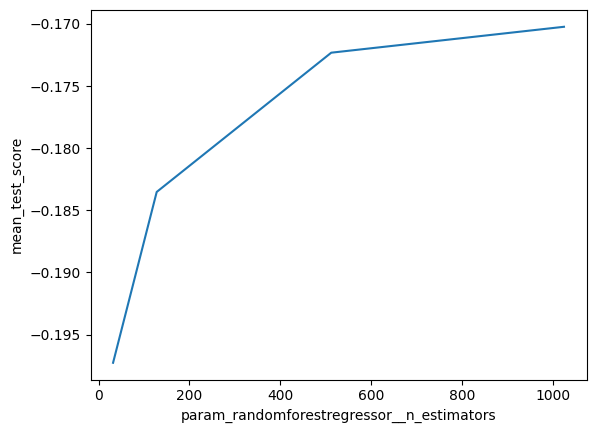

In [54]:

print(train_data := pd.DataFrame(res.cv_results_))

with open('tabela_treino.tex', 'w') as f:
    f.write(train_data.style.to_latex())
    
    
var = 'squared_error'
var2 = 'sqrt'
# mse = train_data.query("param_randomforestregressor__criterion == @var and param_randomforestregressor__max_features == @var2")
mse_df = train_data.query("param_randomforestregressor__criterion == @var")

with open('tabela_treino_mse.tex', 'w') as f:
    f.write(mse_df.style.to_latex())
    
mse_df = mse_df.sort_values('param_randomforestregressor__n_estimators', axis = 0)

# Plot the responses for different events and regions
sns.lineplot(x="param_randomforestregressor__n_estimators", y="mean_test_score",
             #hue="param_randomforestregressor__max_features", # style="event",
             data=train_data)
plt.show()


In [58]:

def mse(y, yref):
    return np.mean(np.square(np.subtract(yref, y)))

def rmse(y, yref):
    return np.sqrt(mse(y, yref))

Linear Regression Model
Train Score:  0.0053029351501218125
Test Score:  0.023960230078556077
Validation Score:  0.03457465557293393
RMSE Score:  41.16118349025078
[0.10187288 3.32326411 3.36482824]


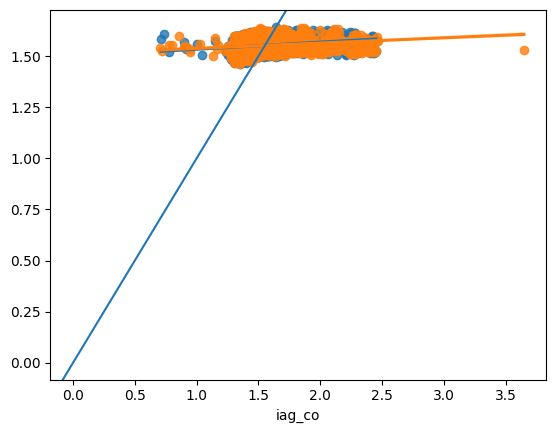

In [59]:
print("Linear Regression Model")
print("Train Score: ", linReg.score(X_train, y_train))
print("Test Score: ", linReg.score(X_test, y_test))
print("Validation Score: ", r2_score(y_valid, linReg.predict(X_valid)))
print("RMSE Score: ", 100*rmse(y_train, linReg.predict(X_train)))

print(linReg.coef_)

sns.regplot(x = y_valid, y = linReg.predict(X_valid))
sns.regplot(x = y_test, y = linReg.predict(X_test))
plt.gca().axline((0,0), slope=1)
plt.show()

In [43]:
# plt.figure(figsize=(15,5))
# plt.plot(df['Time'], df['SO2'])
# plt.title('Variação de SO2 ao longo do tempo')
# plt.xlabel('Data/Hora')
# plt.ylabel('Concentração (ppb)')
# #plt.grid()
# #plt.show()

In [28]:
#Boxplot 

# plt.figure(figsize=(10,5))
# sns.boxplot(x='day', y='SO2', data=df)
# plt.title('Distribuição de SO2 por dia')
# plt.show()

In [29]:
# #analise do horario

# plt.figure(figsize=(10,5))
# sns.lineplot(x='hour', y='SO2', data=df)
# plt.title('Variação média de SO2 por hora')
# plt.show()

In [30]:
# #compara estatitisticas descritivas entre os dias

# df.groupby('day')['SO2'].describe()

In [32]:
#variação de SO2 por dia e hora

# pivot = df.pivot_table(values='SO2', index='hour', columns='day')
# plt.figure(figsize=(10,5))
# sns.heatmap(pivot, cmap='YlOrRd')
# plt.title('Variação de SO2 por hora e dia')
# plt.show()

In [51]:
from sklearn.tree import DecisionTreeRegressor

# Criando a classe DecisionTreeRegressor()
regressor = DecisionTreeRegressor()

# Ajustando o algoritmo a base de dados
regressor.fit(X_train, y_train)

# Prevendo os resultados
y_pred = regressor.predict(X_test)

NameError: name 'X_train' is not defined

In [ ]:
# Comparando os valores reais com os valores previstos
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df.head()

NameError: name 'y_test' is not defined

In [ ]:
import plotly.express as px

# Plotando gráfico
fig = px.line(df, y=['Real Values', 'Predicted Values'])
fig.show()

In [50]:
#dist cumulativa

# plt.figure(figsize=(10,5))
# sns.ecdfplot(data=df, x='SO2')
# plt.title('Distribuição cumulativa de SO2')
# plt.show()

# <font color=yellow>**Parte 3**: Avaliação de desempenho

Principais métricas para avaliação de desempenho de um modelo de regressão:

* **R² (Coeficiente de Determinação)** - varia de 0 a 1 e representa a proporção da variabilidade na variável dependente que pode ser explicada pelo modelo.
* **MAE (Erro Absoluto Médio)** - avalia a precisão de um modelo prever os dados já observados, sendo a média das diferenças absolutas entre as previsões do modelo e os valores reais.
* **MSE (Erro Quadrático Médio)** - também avalia a precisão do modelo, sendo calculado a partir da média das diferenças ao quadrado entre os valores previstos e os valores reais, penalizando mais erros maiores.
* **RMSE (Raiz do Erro Quadrático Médio)** - é a raiz quadrada do MSE, tornando-se assim uma métrica mais fácil de ser interpretar, já que fica na mesma unidade que o dado original.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculando R²
r2 = r2_score(y_test, y_pred)

# Calculando MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculando MSE
mse = mean_squared_error(y_test, y_pred)

# Calculando RMSE
rmse = np.sqrt(mse)

print('R2:', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

Um dos principais problemas do algoritmo da Árvore de Decisão é o **OVERFITTING**: 
- Quando na base de treino o modelo tem um bom desempenho, mas na base de teste tem um desempenho ruim
- O modelo se ajustou de forma tão precisa aos dados de treinamento que aprende o ruído aleatório dos dados, mas não generaliza bem para novos dados.



# <font color=yellow>**Parte 4**: Aplicação do algoritmo RandomForest

Parâmetros:
- n_estimators: número de árvores na floresta
- max_features: número máximo de recursos considerados para dividir um nó
- max_depth: número máximo de níveis em cada árvore de decisão
- random_state: semente usada para gerar números aleatórios durante a execução do modelo

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Criando a classe RandomForestRegressor()
rf_regressor = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18)

# Ajustando o algoritmo a base de dados
rf_regressor.fit(X_train, y_train)

# Prevendo os resultados
y_pred = rf_regressor.predict(X_test)

In [ ]:
# Comparando os valores reais com os valores previstos
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df.head()

In [ ]:
# Plotando gráfico
fig = px.line(df, y=['Real Values', 'Predicted Values'])
fig.show()

# <font color=yellow>**Parte 5**: Avaliação de desempenho

In [ ]:
# Calculando R²
r2 = r2_score(y_test, y_pred)

# Calculando MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculando MSE
mse = mean_squared_error(y_test, y_pred)

# Calculando RMSE
rmse = np.sqrt(mse)

print('R2:', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)